# **Data exploration**
-------------------------------------------

## *TAED2, GCED, UPC BarcelonaTech*
#### *Jesus Antonanzas, Cristina Aguilera, Laia Albors, Sonia Rabanaque*
#### *01-10-2020*

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 0. Objectives and procedure
This notebook consists in the data exploration of the raw data of the TechDebt dataset, with objective of getting relevant insights with respect to different developer profiles. This exploration is divided according to the business objectives and the different hypothesis derived from them. 

# 1. What are the types of developer profiles in our business?

First, we need to make some hypotheses about which attributes can discriminate between profiles and how they must be (which value they must take) in order to represent their particular features.



*   *Hypothesis 1: We can divide each developer profile according to **how long on average they were in the different projects** in which they participated*



We are going to use data stored in the table GIT_COMMIT so we need to read it.

In [ ]:
# read data on git_commits
gitCommit = pd.read_csv("GIT_COMMITS.csv")

In [ ]:
gitCommit.loc[0:4]

,projectID,commitHash,commitMessage,author,authorDate,authorTimezone,committer,committerDate,committerTimezone,branches,inMainBranch,merge,parents
0,accumulo,e0880e263e4bf8662ba3848405200473a25dfc9f,ACCUMULO-1 initial checkin of source code\r\n\...,Keith Turner,2011-10-04T00:46:07Z,0,Keith Turner,2011-10-04T00:46:07Z,0,['master'],True,False,[]
1,accumulo,e8774c5ec3a35e042f320540b5f7e66ebd2d9e87,"ACCUMULO-2 moved cloudtrace for TRUNK, fixed p...",Billie Rinaldi,2011-10-04T16:57:13Z,0,Billie Rinaldi,2011-10-04T16:57:13Z,0,['master'],True,False,['e0880e263e4bf8662ba3848405200473a25dfc9f']
2,accumulo,2032ebbd0ed90734da39ca238bbd10dee24d0030,ACCUMULO-2 fixed thrift build script to point ...,Keith Turner,2011-10-04T18:39:18Z,0,Keith Turner,2011-10-04T18:39:18Z,0,['master'],True,False,['e8774c5ec3a35e042f320540b5f7e66ebd2d9e87']
3,accumulo,de297d4932e08625a5df146f0802041bb5aeb892,ACCUMULO-2 reverted change to config.html\r\n\...,Billie Rinaldi,2011-10-04T19:31:01Z,0,Billie Rinaldi,2011-10-04T19:31:01Z,0,['master'],True,False,['2032ebbd0ed90734da39ca238bbd10dee24d0030']
4,accumulo,34efaae87639a83b60fdb7274de4b45051025a3a,ACCUMULO-2 fixed cloudtrace references in cont...,Billie Rinaldi,2011-10-05T17:19:06Z,0,Billie Rinaldi,2011-10-05T17:19:06Z,0,['master'],True,False,['de297d4932e08625a5df146f0802041bb5aeb892']


Now, we have to compute the new derived attribute. For each committer, we have to  compute the time in days they have spent on each project in which he at least made one commit. This period of time is approximately computed as the difference in days between the first and last commit he made in the project. Finally, to have one single value for each developer, we have to average the days between the different projects. This is equivalent to knowing on average how many days each developer spends working in one project. 

In [ ]:
# Change date from str to datetime
gitCommit['committerDate'] = pd.to_datetime(gitCommit['committerDate'], format='%Y%m%d %H:%M:%S')

# Extract first and last commit for each user and project
duration = gitCommit.groupby(['projectID', 'committer'])['committerDate'].agg(['min', 'max'])

# Compute duration
duration['total_time'] = duration['max'] - duration['min']

# Extract duration in days
duration['days'] = duration['total_time'].dt.days

# Compute mean duration in projects for each commiter
mean_time = duration.groupby(['committer']).mean()

# Extract only user that have work more tha one day in the project
effective_users = mean_time[(mean_time.days != 0)]

The resulting data from the previously described operations can be interpreted as a distribution of probability.

(array([363.,  37.,  32.,  16.,  25.,  27.,  20.,  19.,  20.,  18.,  19.,
         13.,  12.,  17.,   9.,  14.,  10.,  12.,  12.,  11.,   7.,  12.,
         13.,   7.,  13.,  12.,   6.,   5.,   4.,   4.,   6.,   5.,   3.,
          5.,   6.,   4.,   4.,   4.,   4.,   2.,   2.,   6.,   3.,   7.,
          8.,   5.,   7.,   1.,   4.,   3.,   8.,   4.,   3.,   5.,   2.,
          1.,   4.,   4.,   2.,   3.,   3.,   3.,   2.,   3.,   5.,   3.,
          4.,   3.,   2.,   2.,   2.,   3.,   0.,   3.,   2.,   3.,   2.,
          2.,   4.,   1.,   0.,   0.,   3.,   1.,   4.,   0.,   0.,   2.,
          1.,   1.,   1.,   3.,   2.,   0.,   3.,   1.,   1.,   0.,   0.,
          0.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   1.,
          1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   3.,   1.,   0.,
          0.,   0.,   1.,   1.,   1.,   0.,   0.,   1.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   1.,
          0.,   1.,   0.,   0.,   0., 

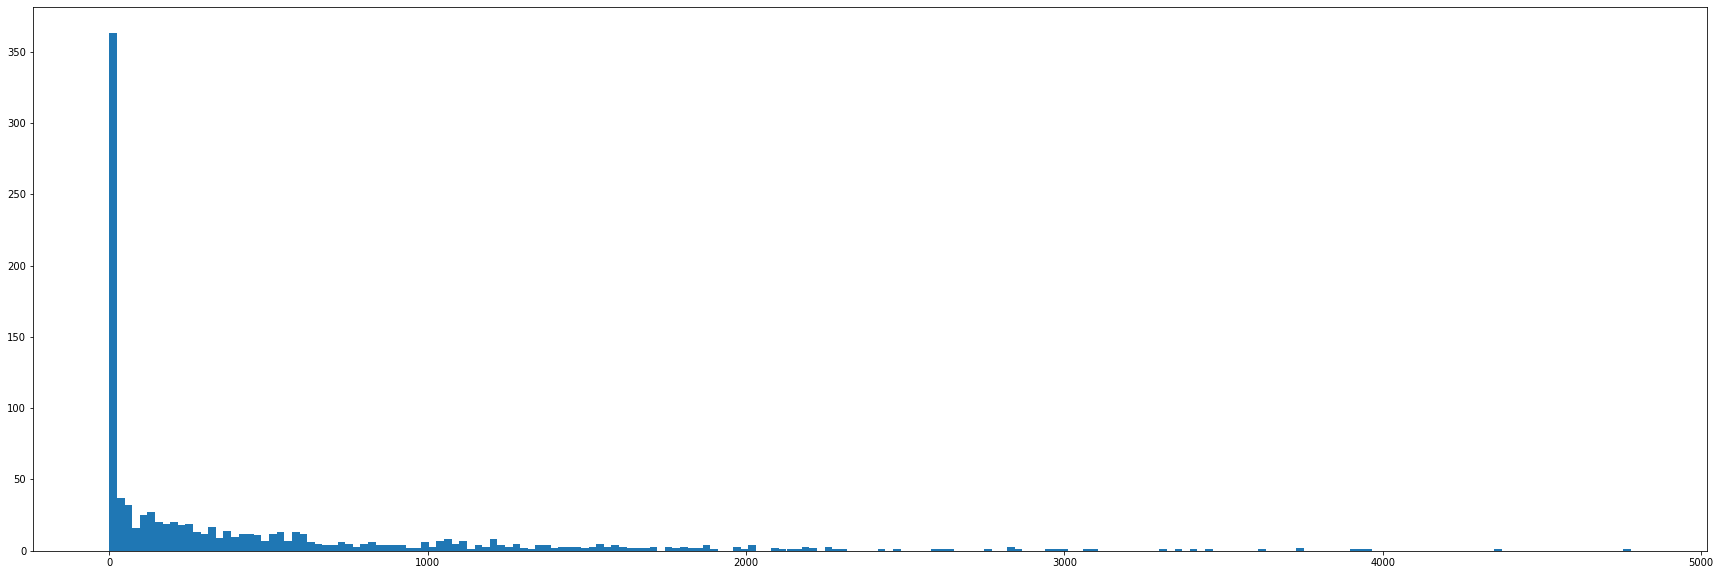

In [ ]:
plt.figure(figsize=(30,10))
plt.hist(mean_time['days'], bins = 200)

we can see three well-defined behaviors.

* Developers who have been very few days working in the project, even 0 days (273 people). They are represented by the first long and concentrated bin that takes between 0 and 24 average work time per developer. They can be considered as contributors to the project but not developers.
* Developers who work on projects for a reasonable period of time in order to develop a good enough final product and not overwhelm it. They are represented by medium high bins that take a moderate range of days.
* Developers who work for lots of days. They are represented by a very short and wide range of days distributed.


We can extract which developers belong to each of the described groups.

In [ ]:
first = effective_users[effective_users.days < 170].sort_values(by='days')
first

,days
committer,
Braden Bassingthwaite,1.000000
Dennis Fusaro,1.000000
Christopher Hyzer,1.000000
Jim Jagielski,1.000000
Lukas Drbal,1.000000
...,...
Dirk Verbeeck,162.705882
Christian van Spaandonk,164.000000
Ben Sidhom,164.000000


In [ ]:
second = effective_users[(effective_users.days > 100) & (effective_users.days < 800)]
second

,days
committer,
Adam Wojtuniak,107.0
Adrian Crum,137.5
Ajit Kumar,120.0
Akhil Subhash Naik,293.0
Alan Myrvold,412.0
...,...
wtanaka.com,326.0
xiliu,202.0
xinyuiscool,333.0


In [ ]:
third = effective_users[effective_users.days > 800].sort_values(by='days')
third

,days
committer,
jfarrell,805.0
Sathya Hariesh,805.0
Thomas Groh,807.0
Goldstein Lyor,809.0
Jason Kuster,816.0
...,...
Richard S. Hall,3898.0
Benjamin Reed,3926.0
Peter Kriens,3953.0




*   *Hypothesis 2: We can divide each developer profile according to the quantity of projects he has worked on*



Again, we are going to use data stored in the table GIT_COMMIT. For each committer, we have to compute the number of different projects he/she has worked on. This is done by counting the number of different projectID on which the developer has made at least one commit.

In [ ]:
projects = gitCommit.groupby(['committer'])['projectID'].agg(['nunique'])

We can now plot de results in a bar chart as they are categorical data.

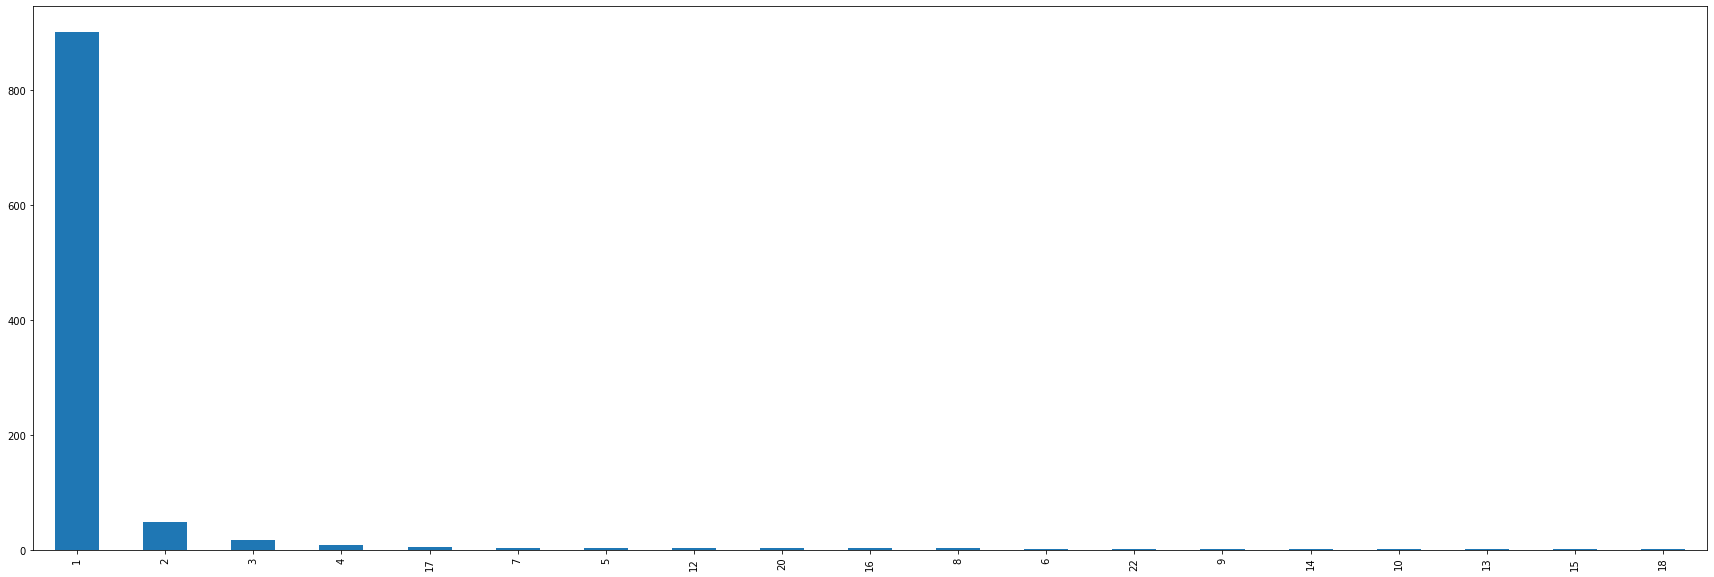

In [ ]:
plt.figure(figsize=(30,10))
projects['nunique'].value_counts().plot(kind='bar')

That way, developers can again be assign to three different profiles:
* Developers that just worked on one single project: 901 developers belong to this group.
* Developers who worked in a moderate number of projects (2-3): 66 developers to the intermediate one.
* Developers that participate in lots of projects (> 3): 49 to the third one.


We can again extract which developers belong to each of the new groups.

In [ ]:
little_projects = projects[projects['nunique'] == 1]
little_projects

,nunique
committer,
(no author),1
-l,1
1028332163,1
A. J. David Bosschaert,1
A195882,1
...,...
Łukasz Gajowy,1
성준영,1
“Erin,1


In [ ]:
medium_projects = projects[(projects['nunique'] > 1) & (projects['nunique'] < 4)]
medium_projects

,nunique
committer,
Adrian Crum,2
Asankha Chamath Perera,2
Benson Margulies,3
Bertrand Delacretaz,2
Bill Speirs,2
...,...
Timothy O'Brien,3
Torsten Curdt,2
Vadim Gritsenko,2


In [ ]:
lots_projects = projects[projects['nunique'] > 3]
lots_projects

,nunique
committer,
Benedikt Ritter,14
Bernd Eckenfels,4
Brett Porter,6
Bruno P. Kinoshita,12
Craig R. McClanahan,7
David Brosius,7
Dennis Lundberg,17
Dion Gillard,16
Dirk Verbeeck,17


In addition we can try to classify the groups obtained with the first hypothesis in this new scenario, obtaining their mean value of projects worked.

In [ ]:
users_first = first.index.values.tolist()
projects[projects.index.isin(users_first)].mean()

nunique    1.562249
dtype: float64

In [ ]:
users_second = second.index.values.tolist()
projects[projects.index.isin(users_second)].mean()

nunique    2.088571
dtype: float64

In [ ]:
users_third = third.index.values.tolist()
projects[projects.index.isin(users_third)].mean()

nunique    1.580189
dtype: float64

As a conclusion,
* Developers who have been very few days working in the project: we obtain a mean value of 1.56, that is, on average all developers in this group tend to work in one or two projects. This is contrary to what we might expect as developers that make small contributions to projects are expected to be working on several projects at the same time.
* Developers who work on projects for a reasonable period: their average of projects is 2.1. This means that this group tends to work in a bit more projects than the previous one.
* Developers who work for lots of days. As we may expect, this type of developers mainly focus on a small number of projects and spend a lot of time working on them. Their mean value is 1.58, more or less similar to the first group.

With this final analysis, we can conclude that the different groups that we detect on both hypotheses are not the same.



*   *Hypothesis 3: We can divide each developer profile according to the **quantity of bugs** they tend to fix* 



This time, we are going to use data stored in the table JIRA_ISSUES.

In [ ]:
jiraIssues = pd.read_csv("JIRA_ISSUES.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (25) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
jiraIssues[0:4]

,projectID,key,creationDate,resolutionDate,updateDate,dueDate,resolution,type,priority,fixVersions,versions,timeSpent,aggregatedTimeSpent,timeEstimate,timeOriginalEstimate,aggregateTimeEstimate,progressPercent,componentName,componentDescription,description,summary,watchCount,votes,labels,creatorName,creatorActive,assignee,reporter
0,commons-exec,EXEC-108,2018-09-18T11:15:58.000+0000,NaN,2018-09-18T11:15:58.000+0000,NaN,NaN,Bug,Major,NaN,['1.3'],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,When using Apache Exec to execute the followin...,Compatibility problem with Android ADB,1.0,NaN,NaN,natanieljr,True,NaN,natanieljr
1,commons-exec,EXEC-107,2018-07-04T12:09:47.000+0000,NaN,2018-07-04T12:09:47.000+0000,NaN,NaN,New Feature,Major,NaN,['1.3'],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Hi,\r\n\r\nI would like to start an independen...",Start independent process,1.0,NaN,NaN,stefanreich,True,NaN,stefanreich
2,commons-exec,EXEC-106,2018-03-06T11:32:51.000+0000,NaN,2018-03-09T15:50:48.000+0000,NaN,NaN,Improvement,Major,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,It looks like the Watchdog class could use vol...,Watchdog class could use volatile instead of s...,1.0,NaN,NaN,sebb,True,NaN,sebb
3,commons-exec,EXEC-105,2018-02-16T13:47:10.000+0000,NaN,2018-02-16T15:37:12.000+0000,NaN,NaN,Wish,Trivial,NaN,['1.3'],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I want to apologize if this issue is not corre...,Small mistakes in the documentation for Apache...,2.0,NaN,NaN,IP,True,NaN,IP
4,commons-exec,EXEC-104,2017-08-04T11:57:39.000+0000,NaN,2017-08-04T11:57:39.000+0000,NaN,NaN,Bug,Major,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[Travis CI reveals the following test failures...,"Test failure ""Exec34Test.testExec34_2:88 Watch...",1.0,NaN,NaN,krichter,True,NaN,krichter
5,commons-exec,EXEC-103,2016-04-18T16:01:22.000+0000,NaN,2016-04-18T16:01:22.000+0000,NaN,NaN,Bug,Major,NaN,['1.3'],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DefaultExecutor is used in https://github.com/...,Hanging during closing the streams; FileInputS...,1.0,NaN,NaN,mma,True,NaN,mma
6,commons-exec,EXEC-102,2016-01-27T22:13:51.000+0000,NaN,2016-04-06T18:42:49.000+0000,NaN,NaN,Bug,Major,NaN,['1.3'],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,When trying to pass an InputStream to a proces...,"""Stream closed"" error in Java 8 when passing i...",2.0,NaN,NaN,cprice-puppet,True,sgoeschl,cprice-puppet
7,commons-exec,EXEC-101,2016-01-26T00:21:06.000+0000,NaN,2016-01-28T20:47:49.000+0000,NaN,NaN,Bug,Major,NaN,['1.3'],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,I encountered a serious glitch when using comm...,IOException when a process terminates before a...,1.0,NaN,NaN,kunda,True,sgoeschl,kunda
8,commons-exec,EXEC-100,2016-01-11T16:45:23.000+0000,2016-01-11T18:01:01.000+0000,2016-01-11T18:01:01.000+0000,NaN,Fixed,Task,Minor,['1.4'],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,The {{OS}} class is a copy & pasta of an outda...,Sync org.apache.commons.exec.OS with the newes...,1.0,NaN,NaN,sgoeschl,True,sgoeschl,sgoeschl
9,commons-exec,EXEC-99,2016-01-09T10:17:48.000+0000,NaN,2016-01-09T16:35:24.000+0000,NaN,NaN,Improvement,Major,['1.4'],['1.3'],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sometimes the current PumpStreamHandler blocks...,Provide a non-blocking PumpStreamHandler,1.0,1.0,NaN,sgoeschl,True,sgoeschl,sgoeschl


For each assignee, we have to cumpute the different issues (different creationDate) for which he/she has fixed the bug of himself or another developer. We must take into account that the resultant developers are going to be the one that made at least one bug fixing.

In [ ]:
bugs = jiraIssues.groupby(['assignee'])['creationDate'].agg(['nunique'])

Next, we plot a bar chart with the result data.

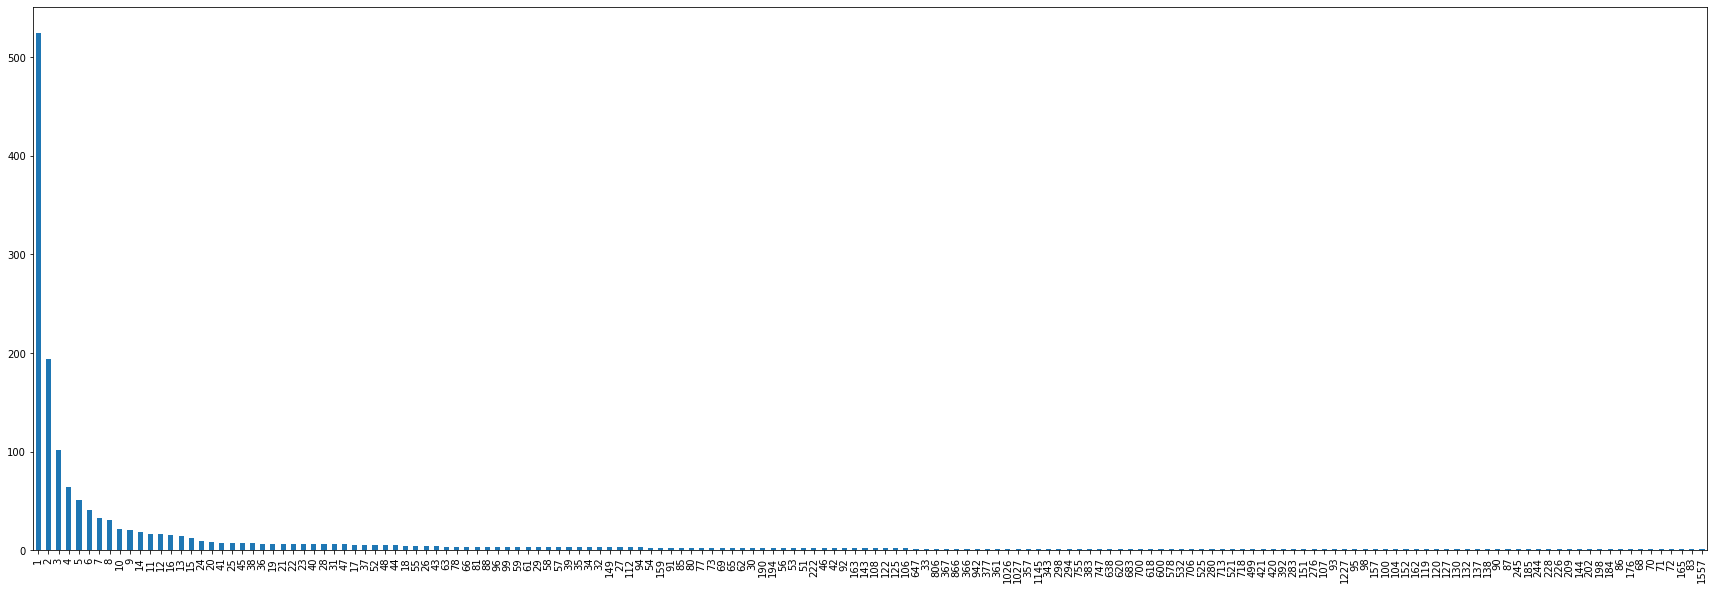

In [ ]:
plt.figure(figsize=(30,10))
bugs['nunique'].value_counts().plot(kind='bar')

We can clearly appreciate that the majority of developers are concentrated in the range of bugs fixed between 1 and 9. A small part of them are spread through values higher than 10. This way, we have identified two different developer behaviours. However, we must take into account another important group: the ones that do not fix any bug. This quantity is quite higher than the quantity of developers that fixed just 1 bug.


Again we can try to relate the different groups of developers obtained with the previous hypotheses.


In [ ]:
users_first = first.index.values.tolist()
bugs[bugs.index.isin(users_first)].mean()

nunique    65.210526
dtype: float64

In [ ]:
users_second = second.index.values.tolist()
bugs[bugs.index.isin(users_second)].mean()

nunique    185.416667
dtype: float64

In [ ]:
users_third = third.index.values.tolist()
bugs[bugs.index.isin(users_third)].mean()

nunique    323.5
dtype: float64

For the first hypothesis,

* Developers who have been very few days working in the project: we obtain a mean value of 65.21, that is, on average all developers in this group tend to fix 65 bugs.
* Developers who work on projects for a reasonable period: their average fixing bugs value is 185.4, that is more than double the value of the previous group.
* Developers who work for lots of days: their mean value is 323.5 of fixed bugs.

In [ ]:
users_little_projects = little_projects.index.values.tolist()
bugs[bugs.index.isin(users_little_projects)].mean()

nunique    134.253968
dtype: float64

In [ ]:
users_medium_projects = medium_projects.index.values.tolist()
bugs[bugs.index.isin(users_medium_projects)].mean()

nunique   NaN
dtype: float64

In [ ]:
users_lots_projects = lots_projects.index.values.tolist()
bugs[bugs.index.isin(users_lots_projects)].mean()

nunique    191.5
dtype: float64

For the second hypothesis,
* Developers that just worked on one single project: in average they are used to fix 134.3 bugs.
* Developers who worked in a moderate number of projects (2-3): we are not able to find any case where these developers solve any bugs.
* Developers that participate in lots of projects (> 3): their mean value is 191.5, which is quite superior to the first case but more or less similar.




*   *Hypothesis 4: We can divide each developer profile according to the  **frequency** of commits* 



We have again used data stored in the table GIT_COMMIT.

In [ ]:
gitCommitsDf = gitCommit

For each committer, we have to compute the total number of commits he/she has done. Then, for the developers with more than one commit, we compute the difference of time between the timestamps of sorted commits in seconds. In order to have just one value for each committer, the mean value of time between commits is performed.

In [ ]:
gitCommitsDf['nCommits'] = 1
ncommits = gitCommitsDf.groupby(by='committer').sum()

In [ ]:
import statistics as stats
frequencies = []
gitCommitsDf = gitCommitsDf.sort_values(by='committerDate', ascending=True)
for author in ncommits.index:
    if ncommits.loc[author, 'nCommits'] == 1:
        continue
    diffs = []
    prevDate = None
    i = 0
    for commitDate in gitCommitsDf.loc[gitCommitsDf['committer'] == author, 'committerDate']:
        if i == 0:
            prevDate = commitDate
            i += 1
        else:
            diffs.append((commitDate - prevDate).total_seconds())
            prevDate = commitDate
    frequencies.append(stats.mean(diffs))
frequencies = [secs / float(3600 * 24) for secs in frequencies]

We can again plot its histograma so we can observe what type of distribution it follows

Text(0.5, 1.0, 'Cumulative density histogram of mean commit frequency by developer')

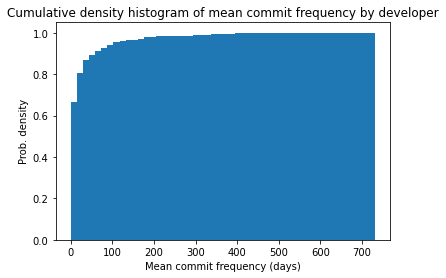

In [ ]:
frequencies.sort()
plt.hist(frequencies, bins = 50, cumulative=True, density=True)
plt.ylabel('Prob. density')
plt.xlabel('Mean commit frequency (days)')
plt.title('Cumulative density histogram of mean commit frequency by developer')

We clearly see that the majority of developers commit at least once every two weeks (about 70% of density). Another 20% of density approximately belongs to developers that commit between once every 2 weeks and once every 3 months (approximately). The 10% left of density belongs to developers that very rarely commit (> 3 months). 